In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
X_train_csv = pd.read_csv('X_train.csv')
y_train_csv = pd.read_csv('y_train.csv')
X_test_csv = pd.read_csv('X_test.csv')

data = pd.merge(X_train_csv, y_train_csv, right_on='Unnamed: 0', left_on='Unnamed: 0')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.set_index("id", inplace=True)

X = data.drop('LeaveOrNot', axis=1)
y = data['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

## Pipline

In [5]:
# def drop_col(df):
#   clean_df = df.drop('Unnamed: 0', axis=1)
#   return clean_df

# func_drop_col = FunctionTransformer(drop_col)

# def set_id_index(data):
#     data.set_index("id", inplace=True)
#     return data

# func_set_index = FunctionTransformer(set_id_index)

NUM_COLS = ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']
CAT_COLS = ['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'Race']

numeric_transformer = Pipeline(steps=[('imputer_num', SimpleImputer(strategy="mean")),
                                      ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                          ('onehot', OneHotEncoder())])

# Combine transformers using ColumnTransformer
column_transformer = ColumnTransformer(transformers=[('num', numeric_transformer, NUM_COLS),
                                                     ('cat', categorical_transformer, CAT_COLS)])

# The final pipeline
preprocess_pipeline = Pipeline(steps=[ # ('set_id_index', func_set_index),
                                       # ('func_drop_col', func_drop_col),
                                      ('col_transformer', column_transformer)])
                                  
preprocess_pipeline

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['JoiningYear', 'Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Education', 'City',
                                                   'PaymentTier', 'Gender',
                                                   'EverBenched', 'Race'])]))])

In [6]:
X_train_proc = column_transformer.fit_transform(X_train)
# Get the feature names for categorical columns after one-hot encoding
# 'onehot' is the name of the OneHotEncoder step in my categorical pipeline
one_hot_feature_names = column_transformer.named_transformers_['cat']['onehot'].get_feature_names_out(CAT_COLS)

# Combine with the numerical column names
all_feature_names = NUM_COLS + list(one_hot_feature_names)

# Convert to DataFrame
X_train_proc_df = pd.DataFrame(X_train_proc, columns=all_feature_names, index=X_train.index)

# Display the first two rows of the processed DataFrame
X_train_proc_df.head(5)

,JoiningYear,Age,ExperienceInCurrentDomain,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,Race_black,Race_red,Race_white,Race_yellow
id,,,,,,,,,,,,,,,,,,,,
2690,1.561559,-0.201236,-0.586232,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3854,-0.581715,2.051725,-0.586232,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3147,1.025740,1.846910,-0.586232,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4339,-0.581715,-0.201236,1.341469,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
291,1.025740,-0.815680,0.056335,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## **Decision Tree Classifier**

In [7]:
dt_clf = DecisionTreeClassifier(random_state=42)

dt_pipeline = Pipeline([('preprocess_pipeline', preprocess_pipeline),
                        ('dt', dt_clf)])

# applying grid search
params = {'dt__max_depth': [10,25,50],
          'dt__min_samples_leaf':[5,10,20],
          'dt__min_samples_split':[15,20,50]}

gs = GridSearchCV(dt_pipeline, param_grid=params, cv=10, scoring='f1')

gs.fit(X_train, y_train)

best_dt_clf = gs.best_estimator_
best_params = gs.best_params_
best_f1_score = gs.best_score_

print("best f1 score:", best_f1_score)
print("Best Parameters:", best_params)

best f1 score: 0.7283505045913594
Best Parameters: {'dt__max_depth': 10, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 15}


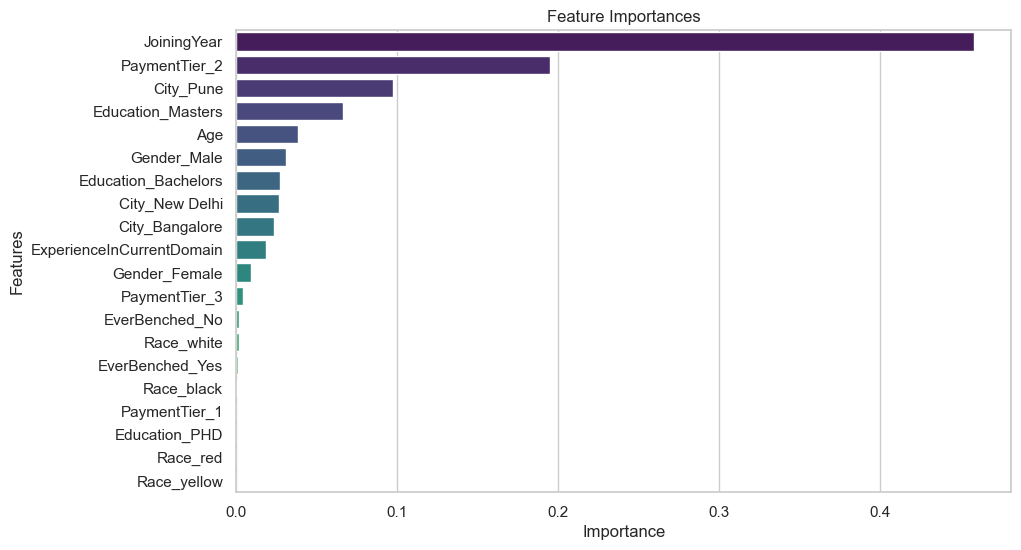

In [45]:
# DT feature importance

best_clf = best_dt_clf.named_steps['dt']
feature_importances = pd.Series(best_clf.feature_importances_ , index=X_train_proc_df.columns) 
sort_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sort_features.values, y=sort_features.index, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

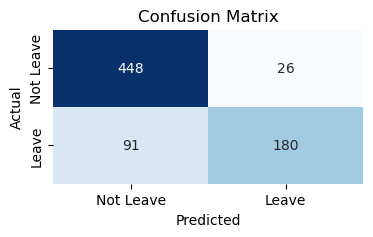

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88       474
           1       0.87      0.66      0.75       271

    accuracy                           0.84       745
   macro avg       0.85      0.80      0.82       745
weighted avg       0.85      0.84      0.84       745



In [9]:
# Make predictions using the best estimator
y_pred = best_dt_clf.predict(X_test)

# Evaluate the model using confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Leave', 'Leave'], yticklabels=['Not Leave', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

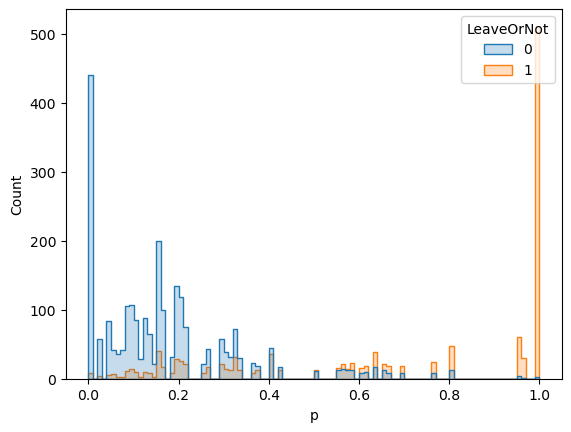

In [10]:
# Illustrative of the probability to leave or not

y_proba_dt = best_dt_clf.predict_proba(X)

leave_probs = pd.DataFrame(y_proba_dt,
                         columns=[f'P({x})' for x in best_dt_clf.classes_],
                         index=data.index)
data_joined = data.join(leave_probs)

df = {"p":data_joined["P(1)"].tolist(),
      "LeaveOrNot" :data_joined['LeaveOrNot']};

ax = sns.histplot(df, x="p", hue="LeaveOrNot",bins=100, element="step")

## Ada Boost Classifier

In [11]:
dt_clf = DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 10, min_samples_split= 15)
adb_clf = AdaBoostClassifier(estimator = dt_clf)

adb_pipeline = Pipeline([('trans_pipeline', preprocess_pipeline),
                        ('adb', adb_clf)])

# applying grid search
params = {'adb__n_estimators': [10,50,100],
          'adb__learning_rate':[0.1,0.5,1]}

gs = GridSearchCV(adb_pipeline, param_grid=params, cv=10, scoring='f1')

gs.fit(X_train, y_train)

best_ada_clf = gs.best_estimator_
best_params = gs.best_params_
best_f1_score = gs.best_score_

print("best f1 score:", best_f1_score)
print("Best Parameters:", best_params)

best f1 score: 0.7271523412620189
Best Parameters: {'adb__learning_rate': 0.1, 'adb__n_estimators': 10}


## **Random Forest**

In [12]:
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Modify the pipeline to use the RandomForestClassifier
rf_pipeline = Pipeline([('trans_pipeline', preprocess_pipeline),
                        ('rf', rf_clf)])

# Grid search parameters for the Random Forest
params_rf = {'rf__n_estimators': [50, 100, 200],
             'rf__max_depth': [15,10,25,50],
             'rf__min_samples_leaf':[20,5,10,20],
             'rf__min_samples_split':[10,15,20,50]}

# Grid search with the Random Forest pipeline
gs_rf = GridSearchCV(rf_pipeline, param_grid=params_rf, cv=10, scoring='f1')
gs_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf_clf = gs_rf.best_estimator_
best_rf_params = gs_rf.best_params_
best_f1_score = gs_rf.best_score_

print("best f1 score:", best_f1_score)
print("Best Parameters:", best_rf_params)

best f1 score: 0.7450846178873699
Best Parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}


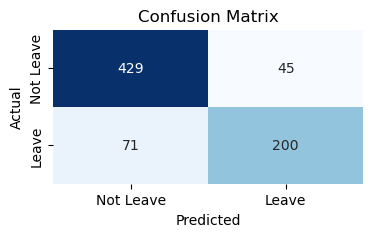

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       474
           1       0.82      0.74      0.78       271

    accuracy                           0.84       745
   macro avg       0.84      0.82      0.83       745
weighted avg       0.84      0.84      0.84       745



In [13]:
# Make predictions using the best estimator
y_pred = best_rf_clf.predict(X_test)

# Evaluate the model using confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Leave', 'Leave'], yticklabels=['Not Leave', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

## XG Boost Classifier

In [14]:
xgb_clf = xgb.XGBClassifier(objective= "binary:hinge", random_state=42)

# Modify the pipeline to use the XGBClassifier
xgb_pipeline = Pipeline([('trans_pipeline', preprocess_pipeline),
                        ('xgb', xgb_clf)])

# Grid search parameters for the XGBClassifier
params_xgb = {'xgb__learning_rate': [0.01, 0.1, 1],
             'xgb__max_depth': [3,4,5],
             'xgb__min_child_weight':[1,2,6]} # represents the minimum sum of instance weights needed in a child (or leaf) node.

# Smaller values of "min_child_weight" allow the algorithm to create deeper trees,
# potentially capturing more intricate patterns in the training data.
# If the value is too high, the algorithm may underfit the data,
# and if it's too low, the model may become overly complex and overfit.

gs_xgb = GridSearchCV(xgb_pipeline, param_grid=params_xgb, cv=10, scoring='f1')

# Train the classifier
gs_xgb.fit(X_train, y_train)

# Best model
best_xgb_clf = gs_xgb.best_estimator_
best_xgb_params = gs_xgb.best_params_
best_f1_score = gs_xgb.best_score_

print("best f1 score:", best_f1_score)
print("Best Parameters:", best_xgb_params)

best f1 score: 0.7497614708756922
Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 2}


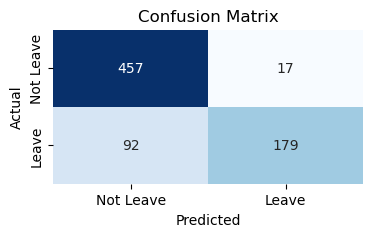

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       474
           1       0.91      0.66      0.77       271

    accuracy                           0.85       745
   macro avg       0.87      0.81      0.83       745
weighted avg       0.86      0.85      0.85       745



In [15]:
# Make predictions using the best estimator
y_pred = best_xgb_clf.predict(X_test)

# Evaluate the model using confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Leave', 'Leave'], yticklabels=['Not Leave', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

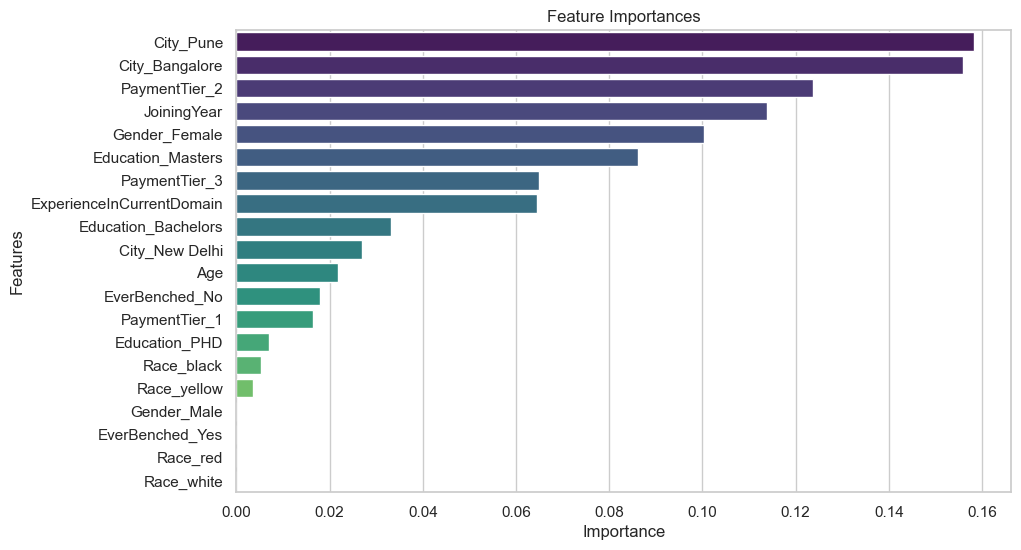

In [46]:
best_clf = best_xgb_clf.named_steps['xgb']

feature_importances = pd.Series(best_clf.feature_importances_ , index=X_train_proc_df.columns) 

sort_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sort_features.values, y=sort_features.index, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## **Logistic Regression Model**

In [17]:
# C= Regularization Strength. a large 'C' means you want a smoother curve that captures
# the general trend without fitting each point precisely
# tol= Tolerance for Stopping Criteria. A larger 'tol' means you're willing to stop
# when you are reasonably close, even if you haven't found the absolute best solution.

lr_model = LogisticRegression(class_weight='balanced')

lr_pipeline = Pipeline([('trans_pipeline', preprocess_pipeline),
                        ('logistic_regression', lr_model)])


lr_params = {'logistic_regression__C': [1, 5, 10],
             'logistic_regression__tol': [0.001, 0.0001, 0.00001]}


gs = GridSearchCV(lr_pipeline, param_grid=lr_params, cv=20, scoring='f1')

gs.fit(X_train, y_train)

# the best model
best_lr_clf = gs.best_estimator_
f1_score = gs.best_score_
best_params = gs.best_params_

print("best f1 score:", f1_score)
print("Best Parameters:", best_params)

best f1 score: 0.6024735215000173
Best Parameters: {'logistic_regression__C': 1, 'logistic_regression__tol': 0.001}


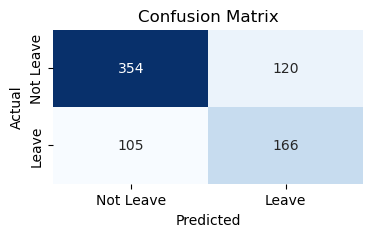

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       474
           1       0.58      0.61      0.60       271

    accuracy                           0.70       745
   macro avg       0.68      0.68      0.68       745
weighted avg       0.70      0.70      0.70       745



In [18]:
# Evaluate the model using confusion matrix. the predictions using the best estimator
y_pred = best_lr_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Leave', 'Leave'], yticklabels=['Not Leave', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

## ROC - AUC

Decision Tree: 0.86
Random Forest: 0.87
Logistic Regression: 0.74
Ada Boost: 0.86
XG Boost: 0.81


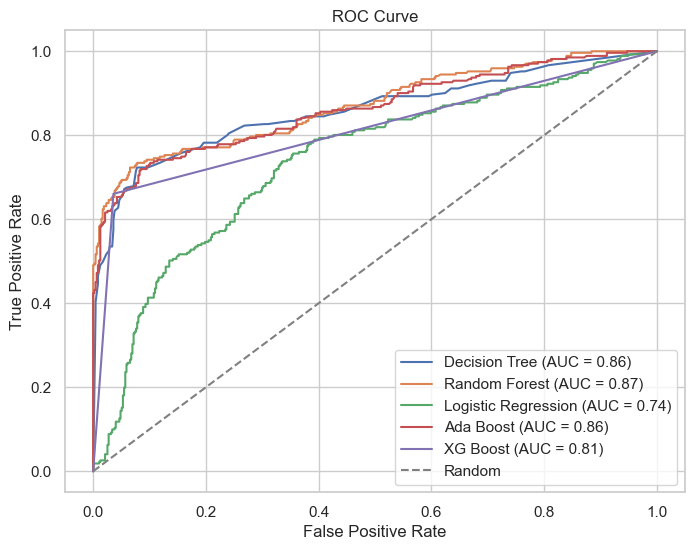

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define classifiers and their best models
classifiers = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Ada Boost', 'XG Boost']
best_clfs = [best_dt_clf, best_rf_clf, best_lr_clf, best_ada_clf, best_xgb_clf]

# Initialize lists to store AUC values and ROC curves
auc_values = []
fpr_values = []
tpr_values = []

# Loop through classifiers
for clf, name in zip(best_clfs, classifiers):
    # Calculate predicted probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)
    auc_values.append(auc)

    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)

    # Print AUC evaluation
    print(f"{name}: {auc:.2f}")

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, fpr, tpr, auc in zip(classifiers, fpr_values, tpr_values, auc_values):
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Voting

In [21]:
# Soft Voting- The predicted class is the one with the highest summed probability across all classifiers.
# the classifier sums up the predicted probabilities for each class from individual classifiers and selects the class
# with the highest sum.

#('best_dt_clf', best_dt_clf)
#('lr_pipeline', lr_pipeline)
#('best_rf_clf', best_rf_clf)
#('best_xgb_clf', best_xgb_clf)

voting_clf = VotingClassifier(estimators= [('best_dt_clf', best_dt_clf), ('best_rf_clf', best_rf_clf)], voting= 'soft')

voting_clf.fit(X_train.iloc[1:1000], y_train.iloc[1:1000])

VotingClassifier(estimators=[('best_dt_clf',
                              Pipeline(steps=[('preprocess_pipeline',
                                               Pipeline(steps=[('col_transformer',
                                                                ColumnTransformer(transformers=[('num',
                                                                                                 Pipeline(steps=[('imputer_num',
                                                                                                                  SimpleImputer()),
                                                                                                                 ('scaler',
                                                                                                                  StandardScaler())]),
                                                                                                 ['JoiningYear',
                                                                                                  'Age',
                                                                                                  'ExperienceInCurrentDomain']),
                                                                                                ('cat',
                                                                                                 Pipeline(steps=[('imputer_cat',
                                                                                                                  SimpleImputer(strategy='mo...
                                                                                                  'ExperienceInCurrentDomain']),
                                                                                                ('cat',
                                                                                                 Pipeline(steps=[('imputer_cat',
                                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                                 ('onehot',
                                                                                                                  OneHotEncoder())]),
                                                                                                 ['Education',
                                                                                                  'City',
                                                                                                  'PaymentTier',
                                                                                                  'Gender',
                                                                                                  'EverBenched',
                                                                                                  'Race'])]))])),
                                              ('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=10,
                                                                      min_samples_leaf=5,
                                                                      min_samples_split=10,
                                                                      n_estimators=200,
                                                                      random_state=42))]))],
                 voting='soft')

In [22]:
accuracy = voting_clf.score(X_test, y_test)
accuracy

0.8416107382550335

In [23]:
y_pred_vote = voting_clf.predict(X_test)

# f1_votting = f1_score(y_test, y_pred_vote)
# print("F1 Score:", f1_votting)

In [24]:
# feature_names = preprocess_pipeline.named_steps['column_transformer'].get_feature_names_out()
# print(feature_names)

## Submission

In [4]:
X_test_csv.drop(columns=['Unnamed: 0'], inplace=True)
X_test_csv.set_index("id", inplace= True)

final_y_pred = best_xgb_clf.predict(X_test_csv)

# Create a dictionary with the predicted values {id: prediction}

prediction_dict = {id_: pred for id_, pred in zip(X_test_csv.index, final_y_pred)}

# Convert NumPy int64 types to native Python int types in the dictionary (JASON requirement)
prediction_dict_converted = {int(id_): int(pred) for id_, pred in prediction_dict.items()}

import json

# convert dictionary to json file
with open('shahar_predictions.json', 'w') as f:
    json.dump(prediction_dict_converted, f)

NameError: name 'best_xgb_clf' is not defined